#**Module de requête**

#imports

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Projet SAFRAN - Module de requête
%ls

/content/drive/MyDrive/Projet SAFRAN - Module de requête
 apprentissage-bouygues/
 apprentissage-bouygues-only-originals/
 apprentissage-bouygues-only-originals-gray/
'couleur ranks_matrix.gsheet'
'couleur score_matrix.csv'
 generate_bouygues_dataset.py
 generate_bouygues_dataset_rgb.py
 models/
'Module de requête.ipynb'
'Module de requête noir et blanc.ipynb'
 output_bouygues.csv
 output_bouygues-only-originals.csv
 photos-bouygues/
 __pycache__/
'ranks_matrix (1).gsheet'
 ranks_matrix.csv
 ranks_matrix.gsheet
 ranks_matrix_tot.csv
 ranks_matrix_tot.gsheet
 ranks_matrix_tot_wb.csv
 request_images/
 request_module_functions.py
 score_matrix0.gsheet
 score_matrix.csv
 score_matrix.gsheet
 score_matrix_tot.csv
 score_matrix_tot.gsheet
 score_matrix_tot_with_bouygues.csv
 tests-bouygues/
 tests-bouygues-sample/


In [ ]:
#%run generate_bouygues_dataset.py

In [3]:
import re
import pathlib
import numpy as np
import pandas as pd
import random 
import time
#data augmentation imports
from skimage import data
from skimage.transform import resize, rotate
from skimage.util import random_noise
from skimage import exposure
from skimage.color import rgb2gray
import scipy.ndimage as ndimage

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

# generate random integer values
from random import randint


class CustomDataset(Dataset):
    """Segmentation & Classification dataset."""

    def __init__(self, folder_inputs,path_csv,list_indexes, transform=None, train=True):
        """
        Args:
            folder_outputs (string): Path to the folder with.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_output = pd.read_csv(path_csv)
        self.folder_inputs = folder_inputs
        self.list_indexes = list_indexes
        self.max_nb_false_pair=40

        if train:
          self.inputs, self.landmarks = self.generate_random_dataset()
        else:
          self.inputs, self.landmarks = self.generate_all_pairs()


        self.transform = transform

    def generate_random_dataset(self):
        df_output = self.data_output.iloc[self.list_indexes, :]
        pairs = []
        output = []
        for class_ in set(df_output['class'].values):
            df_int = df_output[df_output['class']==class_]
            filenames = list(df_int['path'].values)
            for i in range(len(filenames)):
              #for j in range(i+1, len(filenames)):
              for j in range(i+1, min(len(filenames),i+1+self.max_nb_false_pair)):
                  output.append(1)
                  pairs.append([filenames[i], filenames[j]])

        filenames = list(df_output['path'].values)

        for i in range(len(pairs)):
            first_file = filenames[randint(0, len(filenames)-1)]
            class_first_file = int(df_output[df_output['path'] == first_file]['class'].values)
            list_second_file = list(df_output[df_output['class'] != class_first_file]['path'].values)
            output.append(0)
            pairs.append([first_file, list_second_file[randint(0, len(list_second_file)-1)]])
        
        return(pairs, output)

    def generate_all_pairs(self):
      df_output = self.data_output.iloc[self.list_indexes, :]
      pairs = []
      output = []
      filenames = df_output['path'].values
      for i in range(len(filenames)):
        #for j in range(i+1, len(filenames)):
        for j in range(i+1, min(len(filenames),1+i+self.max_nb_false_pair)):
            if len(set(df_output[(df_output['path'] == filenames[i]) | (df_output['path'] == filenames[j])]['class'].values))==1:
              output.append(1)
            else: 
              output.append(0)
            pairs.append([filenames[i], filenames[j]])

      return(pairs, output)


    def __len__(self):
        return len(self.landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        

        landmarks = [self.landmarks[idx]]
        image1 = rgb2gray(plt.imread(self.folder_inputs+self.inputs[idx][0]))
        image2 = rgb2gray(plt.imread(self.folder_inputs+self.inputs[idx][1]))

        pair = np.zeros([2,image2.shape[0], image2.shape[1]])  # 2 is for pairs

        pair[0, :, :] = image1
        pair[1, :, :] = image2

        landmarks = np.array([landmarks])

        if self.transform:
            pair = self.transform(pair)
            pair = torch.transpose(pair, 0, 1)

            landmarks = self.transform(landmarks)
            
        return pair, landmarks


def train_split_dataset(folder_inputs,path_csv, transform=None,size_split=[], train=True):
  datasets = []
  number_indexes = len(pd.read_csv(path_csv))
  list_indexes = [i for i in range(number_indexes)]
  if train:
      train_dataset = CustomDataset(folder_inputs,path_csv,list_indexes, transform, True)
      datasets = [train_dataset]
  else:
      random.shuffle(list_indexes)

      train_indexes = list_indexes[0: int(size_split[0]*len(list_indexes))]
      test_indexes = list_indexes[int(size_split[0]*len(list_indexes)):]

      train_dataset = CustomDataset(folder_inputs,path_csv,train_indexes, transform, True)
      test_dataset = CustomDataset(folder_inputs,path_csv,test_indexes, transform, False)
      datasets = [train_dataset, test_dataset]

  return(datasets)

def get_dataloaders(folder_inputs,path_csv, batch_size, transform=None,size_split=[], train=True):
  dataloaders = []
  datasets = train_split_dataset(folder_inputs,path_csv, transform,size_split, train)
  train_loader = torch.utils.data.DataLoader(datasets[0], batch_size=batch_size, shuffle=True, num_workers=0)
  if train:
      return([train_loader])
  else:
      test_loader = torch.utils.data.DataLoader(datasets[1], batch_size=batch_size, shuffle=True, num_workers=0)
      return([train_loader, test_loader])


class SiameseNetwork(nn.Module):
    def __init__(self, image_size):
        super(SiameseNetwork, self).__init__()
        self.image_size = image_size
        self.device = device
        # Layer 1
        self.conv_1 = nn.Conv2d(in_channels=self.image_size[0], out_channels= 4, kernel_size= 3,padding=1)  
        self.activation_1 = nn.ReLU()
        self.max_pooling_1 = nn.MaxPool2d((5, 5))
        self.dropout_1 = nn.Dropout(p=0.25)

        #layer 2
        self.conv_2 = nn.Conv2d(in_channels= 4, out_channels= 8, kernel_size= 3,padding=1)  
        self.activation_2 = nn.ReLU()
        self.max_pooling_2 = nn.MaxPool2d((5, 5))
        self.dropout_2 = nn.Dropout(p=0.25)

        #layer 3
        self.conv_3 = nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3,padding=1)  
        self.activation_3 = nn.ReLU()
        self.max_pooling_3 = nn.MaxPool2d((2, 2))
        self.dropout_3 = nn.Dropout(p=0.25)    

        # layer 4
        self.linear_4 = nn.Linear(200, 100)
        self.activation_4 = nn.ReLU()

        # layer 5: output
        self.linear_5 = nn.Linear(100, 2)

        

    def forward(self,x):
        #print('in', x.shape)
        x = x.float()
        #layer 1
        x = self.conv_1(x)
        #print('1', x.shape)
        x = self.activation_1(x)
        x = self.max_pooling_1(x)
        x = self.dropout_1(x)

        #layer 2
        x = self.conv_2(x)
        #print('2', x.shape)
        x = self.activation_2(x)
        x = self.max_pooling_2(x)
        x = self.dropout_2(x)
        
        #layer 3
        x = self.conv_3(x)
        #print('3', x.shape)
        x = self.activation_3(x)
        x = self.max_pooling_3(x)
        x = self.dropout_3(x)
        
        #layer 4
        #print('4', x.shape)
        x = x.view(x.size()[0],-1)
        x = self.linear_4(x)
        x = self.activation_4(x)
        
        #layer 5: output
        #print('5', x.shape)
        x = self.linear_5(x)
        x = F.softmax(x, dim=1)
        #print('output', x.shape)
        return  x

def request(network, loader, optimizer, device, set_):
    network.eval()
    preds=[]
    print()
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        output = network(data)
        print(output.data)
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        preds.append(pred)
    return(preds)


def request_scores(network, loader, optimizer, device, set_):
    network.eval()
    scores=[]
    #targets=[]
    for batch_idx, (data, target) in enumerate(loader):
        #target = target.to(device)
        #target_int = torch.flatten(target, start_dim=0)
        #targets.append(target)
        data = data.to(device)
        output = network(data)
        scores.append(output.cpu().data)
    return(scores)

def get_request_loader(folder_inputs,path_csv, request_image, transform=None):
  dataset = CustomDatasetRequest(folder_inputs,path_csv,request_image, transform)
  req_loader = torch.utils.data.DataLoader(dataset,batch_size=1,num_workers=0)
  return(req_loader)

def path_to_original(df_output,index):
  img_class=df_output['class'].values[index]
  mask = (df_output['class']==img_class) & (df_output['original_image']==True)
  return(df_output.loc[mask]['path'].values[0])

def index_of_original(df_output,index):
  img_class=df_output['class'].values[index]
  mask = (df_output['class']==img_class) & (df_output['original_image']==True)
  return(pd.Index(df_output.loc[mask])[0][0])


class CustomDatasetRequest(Dataset):
    """Segmentation & Classification dataset."""

    def __init__(self, folder_inputs,path_csv,request_image, transform=None):
        """
        Args:
            folder_outputs (string): Path to the folder with.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_output = pd.read_csv(path_csv)
        self.folder_inputs = folder_inputs
        self.request_image = request_image

        #self.inputs = self.generate_all_pairs()
        self.inputs,self.landmarks = self.generate_all_pairs()

        self.transform = transform


    def generate_all_pairs(self):
      df_output = self.data_output
      pairs = []
      output = []
      filenames = df_output['path'].values
      for i in range(len(filenames)):
          pairs.append([filenames[i], self.request_image])
          output.append(i)
      return(pairs,output)

    
    def __len__(self):
        return len(self.landmarks)
    """
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        image1 = rgb2gray(plt.imread(self.folder_inputs+self.inputs[idx][0]))
        image2 = rgb2gray(plt.imread(self.folder_inputs+self.inputs[idx][1]))

        pair = np.zeros([2,image2.shape[0], image2.shape[1]])  # 2 is for pairs

        pair[0, :, :] = image1
        pair[1, :, :] = image2
        if self.transform:
            pair = self.transform(pair)
            pair = torch.transpose(pair, 0, 1)
 
        return pair
      """

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()[0]
        

        landmarks = [self.landmarks[idx]]
        image1 = rgb2gray(plt.imread(self.folder_inputs+self.inputs[idx][0]))
        image2 = rgb2gray(plt.imread(self.inputs[idx][1]))

        pair = np.zeros([2,image2.shape[0], image2.shape[1]])  # 2 is for pairs

        pair[0, :, :] = image1
        pair[1, :, :] = image2

        landmarks = np.array([landmarks])

        if self.transform:
            pair = self.transform(pair)
            pair = torch.transpose(pair, 0, 1)

            landmarks = self.transform(landmarks)
            
        return pair, landmarks





#Chargement du modèle

In [4]:
#model_name='./models/snapshot_bouygues_DDP_512_30_0.01_.pt'
#model_name='./models/best_faces.pt'
model_name='./models/network_400_epoch.pt'

#loading the model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print('device :',device)
lr = 0.01
network = SiameseNetwork([2,250, 250])
optimizer = optim.SGD(network.parameters(), lr=lr)
snapshot=torch.load(model_name,map_location='cuda:0')
network.load_state_dict(snapshot,strict=False)
#network.load_state_dict(snapshot['model_state_dict'],strict=False)
#optimizer.load_state_dict(snapshot['optimizer_state_dict'])
network.to(device)
network.eval()

device : cuda:0


SiameseNetwork(
  (conv_1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_1): ReLU()
  (max_pooling_1): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (dropout_1): Dropout(p=0.25, inplace=False)
  (conv_2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_2): ReLU()
  (max_pooling_2): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (dropout_2): Dropout(p=0.25, inplace=False)
  (conv_3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation_3): ReLU()
  (max_pooling_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout_3): Dropout(p=0.25, inplace=False)
  (linear_4): Linear(in_features=200, out_features=100, bias=True)
  (activation_4): ReLU()
  (linear_5): Linear(in_features=100, out_features=2, bias=True)
)

#Requête

In [39]:
request_image='/content/drive/MyDrive/Projet SAFRAN - Module de requête/tests-bouygues-sample/Test 62/20210121_161457.jpg'
#request_image='/content/drive/MyDrive/Projet SAFRAN - Module de requête/tests-bouygues-sample/Test 60/20210121_160231.jpg'
#request_image='/content/drive/MyDrive/Projet SAFRAN - Module de requête/tests-bouygues-sample/Test 36/20210121_160704.jpg'
#request_image='/content/drive/MyDrive/Projet SAFRAN - Module de requête/tests-bouygues-sample/Test 22/20210121_161737.jpg'
dataloader_request = get_request_loader('./apprentissage-bouygues-only-originals-gray/','output_bouygues-only-originals.csv', request_image)

In [40]:
t=time.time()
scores=request_scores(network, dataloader_request, optimizer, device, set_='test')
preds_1=[scores[i].numpy()[0][1] for i in range(len(scores))]
print("temps d'execution : ", time.time()-t)

temps d'execution :  2.661484956741333


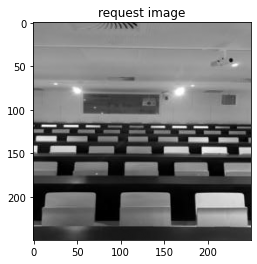

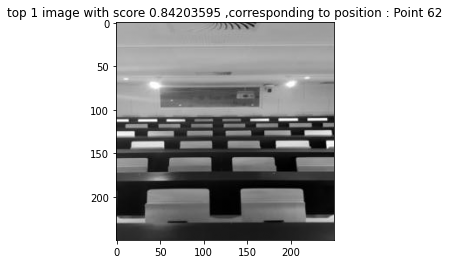

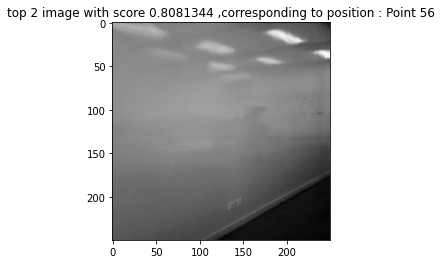

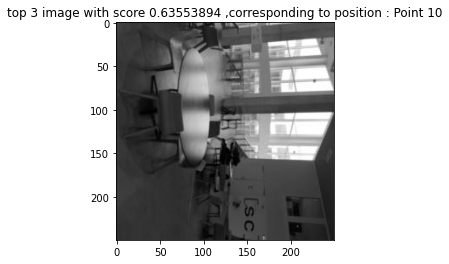

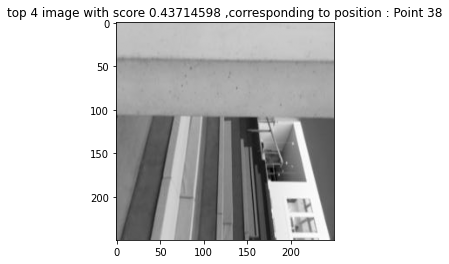

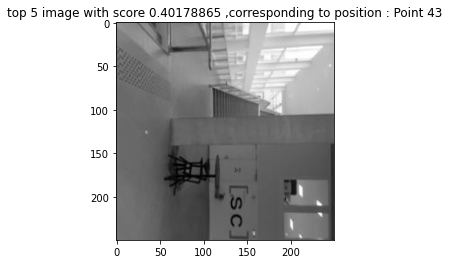

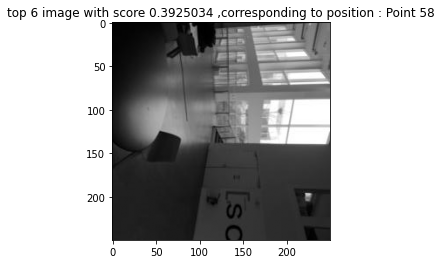

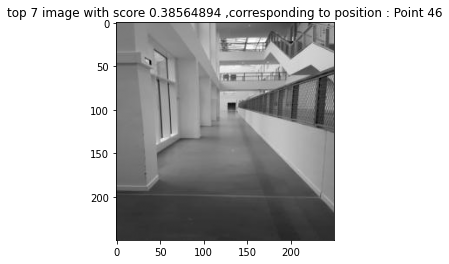

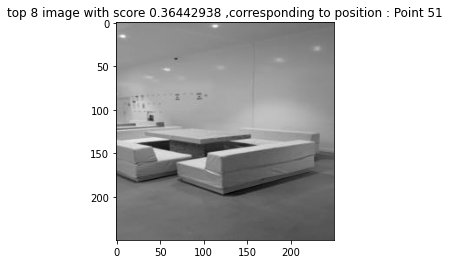

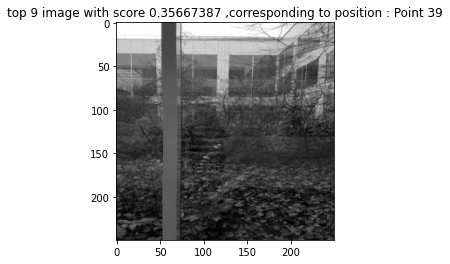

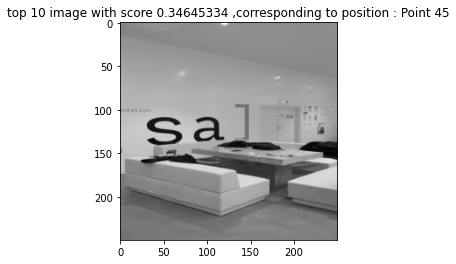

In [41]:
L = [ (preds_1[i],i) for i in range(len(preds_1)) ]
L.sort(reverse=True)
images_scores,ranked_images = zip(*L)

top=10
df_output=pd.read_csv('output_bouygues-only-originals.csv')

plt.figure(0)
plt.title('request image')
req_img=plt.imread(request_image)
req_img=rotate(req_img, 270, resize=True)
plt.imshow(req_img)

for i in range(top):
  plt.figure(i+1)
  plt.title("top "+str(i+1)+" image with score "+str(images_scores[i])+ " ,corresponding to position : " + df_output['position'].values[ranked_images[i]])
  match_0=plt.imread('./apprentissage-bouygues-only-originals-gray/'+df_output['path'].values[ranked_images[i]])
  match_0 = rotate(match_0, 270, resize=True)
  plt.imshow(match_0)

#18 minutes

#Matrice de résultats

In [ ]:
import os
import pandas as pd


folder_test="./tests-bouygues/"
#path vers le dossier contenant toutes les images de test

matrix_dic={}


for subdir, dirs, files in os.walk(folder_test):
    for dir in dirs:
      print(dir)
      for filename in os.listdir(folder_test+dir):
        print(filename)
        request_image = folder_test+dir+'/'+filename
        dataloader_request = get_request_loader('./apprentissage-bouygues-only-originals-gray/','output_bouygues-only-originals.csv', request_image)
        scores=request_scores(network, dataloader_request, optimizer, device, set_='test')
        preds_1=[scores[i].numpy()[0][1] for i in range(len(scores))] 
        matrix_dic[dir+'/'+filename]=preds_1
    df= pd.DataFrame(matrix_dic)
    df.to_csv('score_matrix_tot_with_bouygues_bis.csv', index = True) 

In [16]:
df_output=pd.read_csv('output_bouygues-only-originals.csv')
df = pd.read_csv('score_matrix_tot_with_bouygues_bis.csv')

df_concat = pd.concat([df_output['position'],df],axis=1)

df_concat.to_csv('score_matrix_tot_with_bouygues_bis.csv', index = True) 



In [17]:
columns = df_concat.columns
df_ranked=pd.DataFrame({})
for column in columns[2:]:
  preds_1=df_concat[column]
  L = [ (preds_1[i],i) for i in range(len(preds_1)) ]
  L.sort(reverse=True)
  images_scores,ranked_images = zip(*L)
  df_ranked[column] = [df_output['position'].values[ranked_images[i]] for i in range(len(ranked_images))]
df_ranked.to_csv('ranks_matrix_tot_wb2.csv', index = True) 

In [ ]:
""""
import os
import pandas as pd


folder_test="./tests-bouygues/"
#path vers le dossier contenant toutes les images de test

matrix_dic={}


for subdir, dirs, files in os.walk(folder_test):
    for dir in dirs:
      print(dir)
      for filename in os.listdir(folder_test+dir):
        print(filename)
        original_image = plt.imread(folder_test+dir+'/'+filename)
        original_image = rgb2gray(original_image)
        original_image = resize(original_image, (250, 250),anti_aliasing=True)
        plt.imsave(folder_test+dir+'/'+filename, original_image, cmap='gray')
"""

#Exploitation de la matrice de résultats

In [18]:
df_ranked = pd.read_csv('ranks_matrix_tot_wb2.csv')

df_ranked = df_ranked.iloc[: , 1:]
df_ranked = df_ranked.applymap(lambda x: int(x[6:]))

columns = df_ranked.columns


In [19]:
j=0
for column in columns :
  j+=1
  df_ranked = df_ranked.rename(columns = {column : column.split('/')[0][5:]+'.'+str(j)})
columns = df_ranked.columns

In [20]:
df_ranked.head(10)

,26.1,26.2,26.3,26.4,26.5,14.6,10.7,10.8,10.9,20.10,20.11,20.12,23.13,24.14,24.15,24.16,1.17,1.18,1.19,12.20,12.21,12.22,12.23,22.24,22.25,22.26,22.27,15.28,39.29,39.30,39.31,36.32,36.33,36.34,36.35,42.36,34.37,34.38,41.39,41.40,...,43.74,50.75,50.76,50.77,49.78,49.79,49.80,57.81,57.82,57.83,57.84,52.85,46.86,46.87,46.88,46.89,46.90,61.91,61.92,61.93,61.94,62.95,62.96,62.97,62.98,62.99,62.100,60.101,60.102,60.103,8.104,8.105,8.106,8.107,8.108,59.109,59.110,59.111,59.112,9.113
0,27,27,27,5,27,27,22,9,45,27,27,27,18,27,27,21,19,56,38,5,51,57,32,18,51,18,10,21,36,27,34,62,39,55,39,44,5,47,2,42,...,56,5,56,59,51,46,61,61,53,59,61,46,56,56,51,59,46,27,61,27,27,62,51,62,39,56,62,57,55,49,39,52,52,51,52,49,57,53,61,27
1,46,21,58,51,21,44,19,47,32,58,51,11,4,10,50,60,39,51,59,56,51,59,21,4,36,10,4,61,51,4,50,33,50,51,44,56,51,5,52,55,...,46,5,51,56,51,51,51,9,39,57,62,29,51,44,59,52,53,61,61,21,43,56,56,47,57,62,61,9,55,51,39,51,45,36,9,39,9,46,10,46
2,58,46,44,49,43,39,20,57,51,39,58,10,27,4,39,46,18,34,2,56,51,55,51,39,61,21,50,27,46,44,50,62,55,59,39,36,39,52,56,44,...,44,61,56,57,5,50,56,55,9,39,57,57,5,50,59,49,61,61,5,5,61,10,49,50,57,27,61,5,51,9,47,51,26,53,51,52,5,62,62,55
3,44,46,4,34,50,11,10,46,59,18,60,50,43,43,21,11,44,51,44,34,9,49,31,19,5,27,46,21,56,56,21,39,4,41,46,31,51,52,9,49,...,46,62,5,5,59,51,48,57,57,57,5,60,38,39,51,45,62,61,10,61,56,38,61,61,49,62,56,55,61,51,62,9,5,33,51,49,9,31,33,50
4,50,22,39,36,46,24,10,37,9,21,44,44,58,50,46,10,20,44,51,51,52,9,48,43,44,4,37,43,52,5,5,60,50,44,50,56,44,53,39,56,...,21,51,34,55,48,51,21,52,5,45,39,49,44,50,57,55,10,56,42,37,4,43,45,36,61,46,21,45,9,9,4,44,51,52,44,57,39,47,61,39
5,10,44,43,61,11,25,18,39,57,25,46,60,22,4,44,11,27,5,19,50,39,51,42,17,56,20,27,32,9,2,43,5,51,36,44,56,46,55,34,45,...,51,52,44,45,61,56,42,49,61,49,56,61,5,46,45,59,47,62,32,8,61,58,51,44,55,44,11,59,5,36,50,39,55,42,56,49,45,43,24,10
6,21,59,50,56,46,50,22,45,47,10,50,14,25,46,44,51,4,51,15,39,34,30,41,25,9,46,44,61,52,61,31,51,47,51,50,46,56,18,50,61,...,50,10,44,51,55,47,55,51,52,9,55,56,50,11,34,11,59,55,62,42,62,46,53,46,5,2,27,52,51,52,44,56,52,62,56,9,57,44,21,19
7,61,43,11,51,21,18,23,52,57,21,46,43,25,10,56,27,22,44,34,44,49,5,8,23,5,50,25,37,60,38,44,31,45,29,34,27,5,26,34,5,...,9,49,9,51,59,44,38,60,49,45,31,56,10,44,57,52,33,46,56,61,36,51,9,47,9,36,39,49,44,5,39,44,51,39,52,55,49,26,23,58
8,50,25,10,46,60,60,10,30,59,10,39,21,50,25,50,44,23,24,41,59,44,45,3,2,52,39,21,24,52,57,55,61,5,34,50,27,27,59,34,3,...,44,55,49,44,5,34,5,5,57,5,52,52,42,61,45,59,61,10,42,56,55,39,52,50,60,11,42,51,49,52,39,50,49,45,49,9,49,27,10,46
9,10,60,18,39,20,22,58,57,52,29,50,25,46,58,50,34,10,34,4,52,49,45,2,19,9,10,43,15,33,49,46,49,34,21,34,62,32,9,44,45,...,51,55,44,51,32,34,17,5,52,49,49,51,61,34,49,21,32,53,11,5,33,45,44,39,52,41,5,44,51,56,27,46,49,26,57,57,59,9,52,44


In [21]:
columns = df_ranked.columns
ranking_of_real = []
for column in columns : 
  mask = (df_ranked[column] == np.floor(float(column)))
  try : 
    ranking_of_real.append(df_ranked.loc[mask].index[0])
  except:
    pass
rankings = [i+1 for i in ranking_of_real]
rankings = np.array(rankings)

In [24]:
top = 5
print(rankings)
print(np.mean(rankings))
print(len(np.where(rankings < top+1)[0])/len(rankings))

[175 201 157  91  71  66   4 140  58  18  76  29  48  12  27  28  31  65
  12  19  10  33  34  16  15  14   6  18  62  15  29 114  81 141  67  33
  86 133 159  25  58  14   7   3   2   2  18  18  33   5  60   1 156 187
   7 182  25  33  39  48  38  14  68  16  12  67   4   4   2   3   9  13
   6  40  38   1   2   1   4   3   1  24   1  18   2   1 107  48  43  21
  84  62  44 103  11  10  24  55  43]
44.08080808080808
0.1919191919191919


In [ ]:
df_ranked.head()

,Test 26/20210121_161856.jpg,Test 26/20210121_161858.jpg,Test 26/20210121_161859.jpg,Test 26/20210121_161902.jpg,Test 26/20210121_161905.jpg,Test 14/20210121_161717.jpg,Test 10/20210121_161214.jpg,Test 10/20210121_161218.jpg,Test 10/20210121_161221.jpg,Test 20/20210121_161017.jpg,Test 20/20210121_161019.jpg,Test 20/20210121_161021.jpg,Test 23/20210121_161758.jpg,Test 24/20210121_161818.jpg,Test 24/20210121_161820.jpg,Test 24/20210121_161823.jpg,Test 1/20210121_161310.jpg,Test 1/20210121_161313.jpg,Test 1/20210121_161316.jpg,Test 12/20210121_161154.jpg,Test 12/20210121_161156.jpg,Test 12/20210121_161200.jpg,Test 12/20210121_161203.jpg,Test 22/20210121_161737.jpg,Test 22/20210121_161739.jpg,Test 22/20210121_161741.jpg,Test 22/20210121_161743.jpg,Test 15/20210121_161725.jpg,Test 39/20210121_160747.jpg,Test 39/20210121_160751.jpg,Test 39/20210121_160755.jpg,Test 36/20210121_160702.jpg,Test 36/20210121_160704.jpg,Test 36/20210121_160706.jpg,Test 36/20210121_160711.jpg,Test 42/20210121_160839.jpg,Test 34/20210121_160629.jpg,Test 34/20210121_160632.jpg,Test 41/20210121_160824.jpg,Test 41/20210121_160826.jpg,...,Test 43/20210121_160854.jpg,Test 50/20210121_155235.jpg,Test 50/20210121_155242.jpg,Test 50/20210121_155248.jpg,Test 49/20210121_155214.jpg,Test 49/20210121_155218.jpg,Test 49/20210121_155223.jpg,Test 57/20210121_155856.jpg,Test 57/20210121_155858.jpg,Test 57/20210121_155901.jpg,Test 57/20210121_155903.jpg,Test 52/20210121_155610.jpg,Test 46/20210121_160923.jpg,Test 46/20210121_160924.jpg,Test 46/20210121_160927.jpg,Test 46/20210121_160930.jpg,Test 46/20210121_160935.jpg,Test 61/20210121_161526.jpg,Test 61/20210121_161527.jpg,Test 61/20210121_161529.jpg,Test 61/20210121_161532.jpg,Test 62/20210121_161457.jpg,Test 62/20210121_161459.jpg,Test 62/20210121_161503.jpg,Test 62/20210121_161505.jpg,Test 62/20210121_161507.jpg,Test 62/20210121_161509.jpg,Test 60/20210121_160229.jpg,Test 60/20210121_160231.jpg,Test 60/20210121_160239.jpg,Test 8/20210121_161057.jpg,Test 8/20210121_161111.jpg,Test 8/20210121_161114.jpg,Test 8/20210121_161124.jpg,Test 8/20210121_161130.jpg,Test 59/20210121_155932.jpg,Test 59/20210121_155939.jpg,Test 59/20210121_155945.jpg,Test 59/20210121_160010.jpg,Test 9/20210121_161230.jpg
0,Point 47,Point 34,Point 46,Point 46,Point 56,Point 33,Point 47,Point 45,Point 56,Point 55,Point 51,Point 56,Point 56,Point 52,Point 53,Point 51,Point 56,Point 5,Point 39,Point 33,Point 5,Point 51,Point 56,Point 56,Point 56,Point 27,Point 11,Point 57,Point 27,Point 56,Point 44,Point 44,Point 50,Point 51,Point 56,Point 55,Point 44,Point 30,Point 45,Point 30,...,Point 57,Point 57,Point 27,Point 50,Point 39,Point 51,Point 9,Point 45,Point 51,Point 55,Point 53,Point 29,Point 47,Point 50,Point 53,Point 45,Point 50,Point 56,Point 44,Point 61,Point 31,Point 26,Point 56,Point 57,Point 59,Point 56,Point 45,Point 45,Point 26,Point 51,Point 44,Point 10,Point 56,Point 33,Point 27,Point 51,Point 44,Point 46,Point 52,Point 59
1,Point 33,Point 39,Point 51,Point 51,Point 26,Point 56,Point 61,Point 9,Point 50,Point 56,Point 50,Point 57,Point 56,Point 24,Point 29,Point 50,Point 53,Point 51,Point 27,Point 42,Point 53,Point 56,Point 36,Point 29,Point 9,Point 33,Point 50,Point 56,Point 53,Point 55,Point 53,Point 53,Point 30,Point 44,Point 56,Point 26,Point 51,Point 29,Point 46,Point 51,...,Point 33,Point 39,Point 51,Point 47,Point 59,Point 27,Point 49,Point 49,Point 51,Point 5,Point 57,Point 56,Point 56,Point 57,Point 55,Point 57,Point 45,Point 47,Point 56,Point 44,Point 27,Point 53,Point 57,Point 43,Point 55,Point 47,Point 5,Point 53,Point 26,Point 59,Point 55,Point 57,Point 5,Point 22,Point 29,Point 5,Point 51,Point 55,Point 39,Point 56
2,Point 56,Point 57,Point 47,Point 44,Point 29,Point 5,Point 39,Point 53,Point 44,Point 51,Point 53,Point 11,Point 30,Point 33,Point 61,Point 9,Point 56,Point 55,Point 56,Point 44,Point 49,Point 27,Point 33,Point 59,Point 51,Point 34,Point 56,Point 39,Point 5,Point 51,Point 57,Point 29,Point 27,Point 11,Point 56,Point 4